In [1]:
# IMPORTANT: SOME KAGGLE DATA SOURCES ARE PRIVATE
# RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES.
import kagglehub
# kagglehub.login()
# //read from kaggle.json
from kagglehub.config import set_kaggle_credentials

import json
with open('kaggle.json', 'r') as f:
    kaggle_creds = json.load(f)
    
# kagglehub.login(username=kaggle_creds['username'], key=kaggle_creds['key'])
set_kaggle_credentials(username=kaggle_creds['username'], api_key=kaggle_creds['key'])


Kaggle credentials set.


In [4]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset
import os
import sys
import argparse
from types import SimpleNamespace
import warnings
import time
import gc
warnings.filterwarnings('ignore')

In [2]:
# IMPORTANT: RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES,
# THEN FEEL FREE TO DELETE THIS CELL.
# NOTE: THIS NOTEBOOK ENVIRONMENT DIFFERS FROM KAGGLE'S PYTHON
# ENVIRONMENT SO THERE MAY BE MISSING LIBRARIES USED BY YOUR
# NOTEBOOK.

# drw_crypto_market_prediction_path = kagglehub.competition_download('drw-crypto-market-prediction')

# print('Data source import complete.')


In [ ]:
"""Competition: DRW Crypto Market Prediction | Date: Week 3 | Purpose: Add Back X174"""

import pandas as pd
import numpy as np
import xgboost as xgb
from sklearn.model_selection import StratifiedKFold
from scipy.stats import pearsonr

def reduce_mem_usage(dataframe, dataset):
   print('Reducing memory usage for:', dataset)
   initial_mem_usage = dataframe.memory_usage().sum() / 1024**2

   for col in dataframe.columns:
       col_type = dataframe[col].dtype
       c_min = dataframe[col].min()
       c_max = dataframe[col].max()

       if str(col_type)[:3] == 'int':
           if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
               dataframe[col] = dataframe[col].astype(np.int8)
           elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
               dataframe[col] = dataframe[col].astype(np.int16)
           elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
               dataframe[col] = dataframe[col].astype(np.int32)
           elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
               dataframe[col] = dataframe[col].astype(np.int64)
       else:
           if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
               dataframe[col] = dataframe[col].astype(np.float16)
           elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
               dataframe[col] = dataframe[col].astype(np.float32)
           else:
               dataframe[col] = dataframe[col].astype(np.float64)

   final_mem_usage = dataframe.memory_usage().sum() / 1024**2
   print('--- Memory usage before: {:.2f} MB'.format(initial_mem_usage))
   print('--- Memory usage after: {:.2f} MB'.format(final_mem_usage))
   print('--- Decreased memory usage by {:.1f}%\n'.format(100 * (initial_mem_usage - final_mem_usage) / initial_mem_usage))

   return dataframe

def create_time_weights(n_samples, decay_factor=0.95):
   """Create exponentially decaying weights based on sample position."""
   positions = np.arange(n_samples)
   normalized_positions = positions / (n_samples - 1)
   weights = decay_factor ** (1 - normalized_positions)
   weights = weights * n_samples / weights.sum()
   return weights

# Load data
train = pd.read_parquet(drw_crypto_market_prediction_path + '/train.parquet')
test = pd.read_parquet(drw_crypto_market_prediction_path + '/test.parquet')
sample_submission = pd.read_csv(drw_crypto_market_prediction_path + '/sample_submission.csv')

# Add back X174 (lowest AV importance of removed features)
selected_features = [
   'X863', 'X856', 'X344', 'X598', 'X862', 'X385', 'X852', 'X603', 'X860',
   'X415', 'X345', 'X137', 'X855', 'X178', 'X532', 'X168', 'X174',
   'bid_qty', 'ask_qty', 'buy_qty', 'sell_qty', 'volume'
]

train = train[selected_features + ["label"]]
test = test[selected_features]

train = reduce_mem_usage(train, "train")
test = reduce_mem_usage(test, "test")

print("Train=", train.shape)
print("Test=", test.shape)

FEATURES = [c for c in train.columns if c not in ["label"]]
print(f"There are {len(FEATURES)} FEATURES (added back X174)")

# Cross-validation
FOLDS = 5
kf = StratifiedKFold(n_splits=FOLDS, shuffle=True, random_state=42)

# Create bins for stratification
train['label_float32'] = train['label'].astype(np.float32)
train['label_bins'] = pd.qcut(train['label_float32'], q=10, labels=False, duplicates='drop')
train = train.drop('label_float32', axis=1)

# XGBoost parameters
xgb_params = {
   "tree_method": "hist",
   "device": "cuda",
   "colsample_bylevel": 0.4778015829774066,
   "colsample_bynode": 0.362764358742407,
   "colsample_bytree": 0.7107423488010493,
   "gamma": 1.7094857725240398,
   "learning_rate": 0.02213323588455387,
   "max_depth": 20,
   "max_leaves": 12,
   "min_child_weight": 16,
   "n_estimators": 1667,
   "n_jobs": -1,
   "random_state": 42,
   "reg_alpha": 39.352415706891264,
   "reg_lambda": 75.44843704068275,
   "subsample": 0.06566669853471274,
   "verbosity": 0,
   "objective": "reg:squarederror"
}

# Define model configurations
model_configs = [
   {"name": "Model 1 (100% Full Data)", "percent": 1.00},
   {"name": "Model 2 (90% Recent)", "percent": 0.90},
   {"name": "Model 3 (80% Recent)", "percent": 0.80},
   {"name": "Model 4 (70% Recent)", "percent": 0.70},
   {"name": "Model 5 (60% Recent)", "percent": 0.60},
   {"name": "Model 6 (50% Recent)", "percent": 0.50},
   {"name": "Model 7 (40% Recent)", "percent": 0.40}
]

# Initialize predictions
n_models = len(model_configs)
oof_preds_all = [np.zeros(len(train)) for _ in range(n_models)]
test_preds_all = [np.zeros(len(test)) for _ in range(n_models)]

# Generate sample weights for full data
sample_weights_full = create_time_weights(len(train), decay_factor=0.95)
print(f"\nFull data sample weights range: [{sample_weights_full.min():.4f}, {sample_weights_full.max():.4f}]")

# Calculate cutoffs
cutoffs = []
for config in model_configs:
   if config["percent"] == 1.00:
       cutoffs.append(0)
   else:
       cutoff_idx = int(len(train) * (1 - config["percent"]))
       cutoffs.append(cutoff_idx)
       print(f"{config['name']} - Using most recent {len(train) - cutoff_idx} samples")

# Cross-validation loop
for fold_num, (train_idx, valid_idx) in enumerate(kf.split(train, train['label_bins'])):
   print("\n" + "#" * 50)
   print(f"### Fold {fold_num + 1}")
   print("#" * 50)

   X_valid = train.iloc[valid_idx][FEATURES]
   y_valid = train.iloc[valid_idx]["label"]
   X_test = test[FEATURES]

   # Train each model
   for model_idx, (config, cutoff) in enumerate(zip(model_configs, cutoffs)):
       print(f"\n--- {config['name']} ---")

       if config["percent"] == 1.00:
           X_train = train.iloc[train_idx][FEATURES]
           y_train = train.iloc[train_idx]["label"]
           train_weights = sample_weights_full[train_idx]
       else:
           train_idx_recent = train_idx[train_idx >= cutoff]
           train_idx_recent_adjusted = train_idx_recent - cutoff
           train_recent = train.iloc[cutoff:].reset_index(drop=True)

           X_train = train_recent.iloc[train_idx_recent_adjusted][FEATURES]
           y_train = train_recent.iloc[train_idx_recent_adjusted]["label"]

           sample_weights_recent = create_time_weights(len(train_recent), decay_factor=0.95)
           train_weights = sample_weights_recent[train_idx_recent_adjusted]

       # Train model
       model = xgb.XGBRegressor(**xgb_params, early_stopping_rounds=25)
       model.fit(
           X_train, y_train,
           sample_weight=train_weights,
           eval_set=[(X_valid, y_valid)],
           verbose=200
       )

       # Make predictions
       if config["percent"] == 1.00:
           oof_preds_all[model_idx][valid_idx] = model.predict(X_valid)
       else:
           valid_idx_in_range = valid_idx[valid_idx >= cutoff]
           if len(valid_idx_in_range) > 0:
               X_valid_subset = train.iloc[valid_idx_in_range][FEATURES]
               oof_preds_all[model_idx][valid_idx_in_range] = model.predict(X_valid_subset)

           valid_idx_out_range = valid_idx[valid_idx < cutoff]
           if len(valid_idx_out_range) > 0:
               oof_preds_all[model_idx][valid_idx_out_range] = oof_preds_all[0][valid_idx_out_range]

       test_preds_all[model_idx] += model.predict(X_test)

# Average test predictions across folds
for i in range(n_models):
   test_preds_all[i] /= FOLDS

# Calculate individual model scores
pearson_scores = []
for i, config in enumerate(model_configs):
   score = pearsonr(train["label"], oof_preds_all[i])[0]
   pearson_scores.append(score)

print("\n" + "=" * 50)
print("INDIVIDUAL MODEL PERFORMANCE (+X174)")
print("=" * 50)
for config, score in zip(model_configs, pearson_scores):
   print(f"{config['name']} Pearson Correlation: {score:.4f}")

# Create ensemble predictions
ensemble_oof_preds = np.mean(oof_preds_all, axis=0)
ensemble_test_preds = np.mean(test_preds_all, axis=0)

ensemble_pearson_score = pearsonr(train["label"], ensemble_oof_preds)[0]
print(f"\nEnsemble (Equal Weight) Pearson Correlation: {ensemble_pearson_score:.4f}")

# Weighted ensemble
total_score = sum(pearson_scores)
weights = [score / total_score for score in pearson_scores]

weighted_ensemble_oof = np.zeros(len(train))
weighted_ensemble_test = np.zeros(len(test))

for i in range(n_models):
   weighted_ensemble_oof += weights[i] * oof_preds_all[i]
   weighted_ensemble_test += weights[i] * test_preds_all[i]

weighted_ensemble_score = pearsonr(train["label"], weighted_ensemble_oof)[0]
print(f"Weighted Ensemble Pearson Correlation: {weighted_ensemble_score:.4f}")

# Use the better ensemble
if weighted_ensemble_score > ensemble_pearson_score:
   final_test_preds = weighted_ensemble_test
   print("\nUsing weighted ensemble for final predictions")
else:
   final_test_preds = ensemble_test_preds
   print("\nUsing simple average ensemble for final predictions")


In [ ]:
# Alternative approach: Simple transformer benchmark using PyTorch directly
# This doesn't require the full Time-Series-Library framework
import torch
import torch.nn as nn
import numpy as np
import time
from torch.utils.data import DataLoader, Dataset


class SimpleTransformerModel(nn.Module):
    """A simple transformer model for time series forecasting"""
    def __init__(self, input_dim, d_model=128, nhead=8, num_layers=2, seq_len=96, pred_len=24):
        super().__init__()
        self.input_dim = input_dim
        self.d_model = d_model
        self.seq_len = seq_len
        self.pred_len = pred_len
        
        # Input projection
        self.input_projection = nn.Linear(input_dim, d_model)
        
        # Positional encoding
        self.pos_encoding = nn.Parameter(torch.randn(seq_len, d_model))
        
        # Transformer encoder
        encoder_layer = nn.TransformerEncoderLayer(
            d_model=d_model, 
            nhead=nhead, 
            batch_first=True
        )
        self.transformer = nn.TransformerEncoder(encoder_layer, num_layers=num_layers)
        
        # Output projection
        self.output_projection = nn.Linear(d_model, 1)
        
        # Prediction head
        self.prediction_head = nn.Linear(seq_len, pred_len)
        
    def forward(self, x):
        # x shape: (batch_size, seq_len, input_dim)
        batch_size = x.size(0)
        
        # Project input to model dimension
        x = self.input_projection(x)  # (batch_size, seq_len, d_model)
        
        # Add positional encoding
        x = x + self.pos_encoding.unsqueeze(0)  # Broadcasting
        
        # Apply transformer
        x = self.transformer(x)  # (batch_size, seq_len, d_model)
        
        # Project to single output dimension
        x = self.output_projection(x)  # (batch_size, seq_len, 1)
        x = x.squeeze(-1)  # (batch_size, seq_len)
        
        # Project to prediction length
        predictions = self.prediction_head(x)  # (batch_size, pred_len)
        
        return predictions.unsqueeze(-1)  # (batch_size, pred_len, 1)

def run_simple_transformer_benchmark(train_data, val_data, test_data, data_info):
    """Run a simple transformer benchmark"""
    print("🚀 Running Simple Transformer Benchmark...")
    
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    print(f"Using device: {device}")
    
    # Prepare data
    seq_len, pred_len = 96, 24
    
    # Create datasets
    train_dataset = CryptoDataset(train_data, seq_len=seq_len, pred_len=pred_len)
    val_dataset = CryptoDataset(val_data, seq_len=seq_len, pred_len=pred_len)
    test_dataset = CryptoDataset(test_data, seq_len=seq_len, pred_len=pred_len)
    
    # Create data loaders
    train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True, num_workers=0)
    val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False, num_workers=0)
    test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False, num_workers=0)
    
    # Initialize model
    model = SimpleTransformerModel(
        input_dim=data_info['n_features'],
        d_model=128,
        nhead=8,
        num_layers=2,
        seq_len=seq_len,
        pred_len=pred_len
    ).to(device)
    
    # Training setup
    criterion = nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
    
    # Training loop
    print("Training the model...")
    start_time = time.time()
    
    model.train()
    for epoch in range(5):  # Quick training for benchmark
        total_loss = 0
        for batch_idx, (batch_x, batch_y, _, _) in enumerate(train_loader):
            batch_x = batch_x.float().to(device)
            batch_y = batch_y[:, -pred_len:, -1:].float().to(device)  # Last pred_len steps, target feature
            
            optimizer.zero_grad()
            outputs = model(batch_x)
            loss = criterion(outputs, batch_y)
            loss.backward()
            optimizer.step()
            
            total_loss += loss.item()
            
            if batch_idx % 50 == 0:
                print(f"Epoch {epoch+1}, Batch {batch_idx}, Loss: {loss.item():.6f}")
    
    training_time = time.time() - start_time
    print(f"Training completed in {training_time:.2f} seconds")
    
    # Testing
    print("Testing the model...")
    test_start = time.time()
    
    model.eval()
    predictions = []
    targets = []
    
    with torch.no_grad():
        for batch_x, batch_y, _, _ in test_loader:
            batch_x = batch_x.float().to(device)
            batch_y = batch_y[:, -pred_len:, -1:].float()  # Target values
            
            outputs = model(batch_x).cpu()
            
            predictions.append(outputs.numpy())
            targets.append(batch_y.numpy())
    
    # Concatenate predictions
    predictions = np.concatenate(predictions, axis=0)
    targets = np.concatenate(targets, axis=0)
    
    testing_time = time.time() - test_start
    
    # Calculate metrics
    predictions_flat = predictions.flatten()
    targets_flat = targets.flatten()
    
    mse = np.mean((predictions_flat - targets_flat) ** 2)
    rmse = np.sqrt(mse)
    mae = np.mean(np.abs(predictions_flat - targets_flat))
    
    # Calculate correlation
    correlation = np.corrcoef(predictions_flat, targets_flat)[0, 1]
    
    # Model parameters
    total_params = sum(p.numel() for p in model.parameters())
    
    result = {
        'model': 'Simple Transformer',
        'mae': mae,
        'mse': mse,
        'rmse': rmse,                                
        'mape': np.mean(np.abs((targets_flat - predictions_flat) / (targets_flat + 1e-8))) * 100,
        'correlation': correlation,
        'training_time': training_time,
        'testing_time': testing_time,
        'total_params': total_params,
        'status': 'Success'
    }
    
    print(f"✅ Simple Transformer completed!")
    print(f"Correlation: {correlation:.6f}, RMSE: {rmse:.6f}")
    
    return result

print("🛠️ Simple transformer benchmark ready!")


🛠️ Simple transformer benchmark ready!


In [ ]:

# Save predictions
sample_sub = pd.read_csv('/Users/mahta/Projects/Time-Series-Library/data/drw-crypto-market-prediction/sample_submission.csv')
submission = pd.DataFrame({
   sample_sub.columns[0]: sample_sub.iloc[:, 0],
   'prediction': final_test_preds
})
submission.to_csv("submission_with_X174.csv", index=False)
print("\nSubmission saved to submission_with_X174.csv!")

# Gap-first validation
cv_scores = [np.sqrt(np.mean((train["label"] - oof_preds_all[i])**2)) for i in range(n_models)]
cv_mean = np.mean(cv_scores)
cv_std = np.std(cv_scores)

print(f"\n=== GAP-FIRST VALIDATION ===")
print(f"Ensemble Pearson: {weighted_ensemble_score:.4f}")
print(f"Model RMSE Std: {cv_std:.6f}")
print(f"Features: {len(FEATURES)} (added back X174)")

if cv_std < 0.01 and weighted_ensemble_score > 0.4:
   print("✅ SUBMIT: High correlation and stable models")
else:
   print("⚠️  CAUTION: Review before submission")

## Timeseries Time!

In [ ]:
"""
Time-Series Transformer Benchmark for Crypto Prediction
Let's prepare the data and benchmark multiple transformer models from the library
"""



# Import the Time-Series-Library modules
sys.path.append('/Users/mahta/Projects/Time-Series-Library')

# Try to import the required modules with error handling
try:
    from exp.exp_long_term_forecasting import Exp_Long_Term_Forecast
    from utils.metrics import metric
    from utils.tools import EarlyStopping, adjust_learning_rate
    print("✅ Time-Series-Library modules imported successfully!")
except ImportError as e:
    print(f"⚠️ Import error: {e}")
    print("Some functionality may be limited, but we'll continue with available components.")

# Create a custom dataset class for our crypto data
class CryptoDataset(Dataset):
    def __init__(self, data, seq_len=96, label_len=48, pred_len=24):
        self.data = data
        self.seq_len = seq_len
        self.label_len = label_len  
        self.pred_len = pred_len
        
        # Prepare features (everything except label)
        self.features = [col for col in data.columns if col != 'label']
        self.data_x = data[self.features].values
        self.data_y = data['label'].values.reshape(-1, 1)
        
        # Normalize the data
        self.data_x = (self.data_x - self.data_x.mean(axis=0)) / (self.data_x.std(axis=0) + 1e-8)
        self.data_y = (self.data_y - self.data_y.mean()) / (self.data_y.std() + 1e-8)
        
    def __len__(self):
        return len(self.data_x) - self.seq_len - self.pred_len + 1
    
    def __getitem__(self, index):
        s_begin = index
        s_end = s_begin + self.seq_len
        r_begin = s_end - self.label_len
        r_end = r_begin + self.label_len + self.pred_len
        
        seq_x = self.data_x[s_begin:s_end]
        seq_y = self.data_y[r_begin:r_end]
        
        # Create dummy time marks (zeros for now)
        seq_x_mark = np.zeros((self.seq_len, 1))
        seq_y_mark = np.zeros((self.label_len + self.pred_len, 1))
        
        return seq_x, seq_y, seq_x_mark, seq_y_mark

# Function to create args for different models
def create_model_args(model_name, data_info):
    args = SimpleNamespace()
    
    # Basic configuration
    args.task_name = 'long_term_forecast'
    args.is_training = 1
    args.model_id = f'crypto_{model_name}'
    args.model = model_name
    
    # Data configuration
    args.data = 'custom'
    args.features = 'M'  # Multivariate
    args.target = 'label'
    args.freq = 't'  # minutely
    args.checkpoints = './checkpoints/'
    
    # Model dimensions
    args.seq_len = 96
    args.label_len = 48
    args.pred_len = 24
    args.enc_in = data_info['n_features']
    args.dec_in = data_info['n_features'] 
    args.c_out = 1  # predicting single target
    
    # Model architecture
    args.d_model = 128
    args.n_heads = 8
    args.e_layers = 2
    args.d_layers = 1
    args.d_ff = 256
    args.dropout = 0.1
    args.activation = 'gelu'
    args.embed = 'timeF'
    args.distil = True
    args.factor = 1
    args.moving_avg = 25
    
    # Training configuration
    args.batch_size = 64
    args.learning_rate = 0.0001
    args.train_epochs = 10
    args.patience = 3
    args.des = f'{model_name}_benchmark'
    args.itr = 1
    args.loss = 'MSE'
    args.lradj = 'type1'
    args.use_amp = False
    
    # Device configuration
    args.use_gpu = torch.cuda.is_available()
    args.gpu = 0
    args.use_multi_gpu = False
    args.device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    
    # Model-specific parameters
    if model_name == 'TimesNet':
        args.top_k = 5
        args.num_kernels = 6
    elif model_name == 'PatchTST':
        args.patch_len = 16
        args.stride = 8
    elif model_name == 'iTransformer':
        args.use_norm = 1
    elif model_name == 'Mamba':
        args.expand = 2
        args.d_conv = 4
    elif model_name == 'TimeMixer':
        args.down_sampling_layers = 3
        args.down_sampling_method = 'avg'
        args.down_sampling_window = 2
    
    return args

print("✅ Time-Series Library setup complete!")
print("Available models for benchmarking...")

# List of transformer models to benchmark
transformer_models = [
    'Transformer', 'Informer', 'Autoformer', 'FEDformer', 
    'TimesNet', 'PatchTST', 'iTransformer', 'Mamba',
    'TimeMixer', 'TSMixer', 'Crossformer', 'ETSformer'
]

print(f"Models to benchmark: {transformer_models}")


⚠️ Import error: No module named 'exp'
Some functionality may be limited, but we'll continue with available components.
✅ Time-Series Library setup complete!
Available models for benchmarking...
Models to benchmark: ['Transformer', 'Informer', 'Autoformer', 'FEDformer', 'TimesNet', 'PatchTST', 'iTransformer', 'Mamba', 'TimeMixer', 'TSMixer', 'Crossformer', 'ETSformer']


In [ ]:
# Prepare the data for time series forecasting
print("📊 Preparing crypto data for time series modeling...")

# Load the data
drw_crypto_market_prediction_path = 'data/'
train_ts = pd.read_parquet(drw_crypto_market_prediction_path + '/train.parquet')
test_ts = pd.read_parquet(drw_crypto_market_prediction_path + '/test.parquet')

print(f"Train data shape: {train_ts.shape}")
print(f"Test data shape: {test_ts.shape}")

# Use the same features as our XGBoost model
selected_features = [
    'X863', 'X856', 'X344', 'X598', 'X862', 'X385', 'X852', 'X603', 'X860',
    'X415', 'X345', 'X137', 'X855', 'X178', 'X532', 'X168', 'X174',
    'bid_qty', 'ask_qty', 'buy_qty', 'sell_qty', 'volume'
]

# Prepare training data
train_ts_features = train_ts[selected_features + ['label']].copy()

# Create time index (assuming sequential data)
train_ts_features = train_ts_features.reset_index(drop=True)

# Split into train/val/test for time series (70/15/15 split)
n_samples = len(train_ts_features)
train_size = int(0.7 * n_samples)
val_size = int(0.15 * n_samples)

ts_train = train_ts_features[:train_size].copy()
ts_val = train_ts_features[train_size:train_size+val_size].copy()
ts_test = train_ts_features[train_size+val_size:].copy()

print(f"Time series splits - Train: {len(ts_train)}, Val: {len(ts_val)}, Test: {len(ts_test)}")

# Data info for models
data_info = {
    'n_features': len(selected_features),
    'n_samples_train': len(ts_train),
    'n_samples_val': len(ts_val),
    'n_samples_test': len(ts_test)
}

print(f"Data info: {data_info}")

# Check for any missing values
print(f"Missing values in training data: {ts_train.isnull().sum().sum()}")
if ts_train.isnull().sum().sum() > 0:
    print("Filling missing values with forward fill...")
    ts_train = ts_train.fillna(method='ffill').fillna(method='bfill')
    ts_val = ts_val.fillna(method='ffill').fillna(method='bfill')
    ts_test = ts_test.fillna(method='ffill').fillna(method='bfill')

# save the ready data to pickle
with open('data/ts_train.pkl', 'wb') as f:
    pickle.dump(ts_train, f)
with open('data/ts_val.pkl', 'wb') as f:
    pickle.dump(ts_val, f)
with open('data/ts_test.pkl', 'wb') as f:
    pickle.dump(ts_test, f)



print("✅ Data preparation complete!")


📊 Preparing crypto data for time series modeling...


In [ ]:
# Alternative approach: Simple transformer benchmark using PyTorch directly
# This doesn't require the full Time-Series-Library framework
import torch
import torch.nn as nn
import numpy as np
import time
from torch.utils.data import DataLoader, Dataset


class SimpleTransformerModel(nn.Module):
    """A simple transformer model for time series forecasting"""
    def __init__(self, input_dim, d_model=128, nhead=8, num_layers=2, seq_len=96, pred_len=24):
        super().__init__()
        self.input_dim = input_dim
        self.d_model = d_model
        self.seq_len = seq_len
        self.pred_len = pred_len
        
        # Input projection
        self.input_projection = nn.Linear(input_dim, d_model)
        
        # Positional encoding
        self.pos_encoding = nn.Parameter(torch.randn(seq_len, d_model))
        
        # Transformer encoder
        encoder_layer = nn.TransformerEncoderLayer(
            d_model=d_model, 
            nhead=nhead, 
            batch_first=True
        )
        self.transformer = nn.TransformerEncoder(encoder_layer, num_layers=num_layers)
        
        # Output projection
        self.output_projection = nn.Linear(d_model, 1)
        
        # Prediction head
        self.prediction_head = nn.Linear(seq_len, pred_len)
        
    def forward(self, x):
        # x shape: (batch_size, seq_len, input_dim)
        batch_size = x.size(0)
        
        # Project input to model dimension
        x = self.input_projection(x)  # (batch_size, seq_len, d_model)
        
        # Add positional encoding
        x = x + self.pos_encoding.unsqueeze(0)  # Broadcasting
        
        # Apply transformer
        x = self.transformer(x)  # (batch_size, seq_len, d_model)
        
        # Project to single output dimension
        x = self.output_projection(x)  # (batch_size, seq_len, 1)
        x = x.squeeze(-1)  # (batch_size, seq_len)
        
        # Project to prediction length
        predictions = self.prediction_head(x)  # (batch_size, pred_len)
        
        return predictions.unsqueeze(-1)  # (batch_size, pred_len, 1)

def run_simple_transformer_benchmark(train_data, val_data, test_data, data_info):
    """Run a simple transformer benchmark"""
    print("🚀 Running Simple Transformer Benchmark...")
    
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    print(f"Using device: {device}")
    
    # Prepare data
    seq_len, pred_len = 96, 24
    
    # Create datasets
    train_dataset = CryptoDataset(train_data, seq_len=seq_len, pred_len=pred_len)
    val_dataset = CryptoDataset(val_data, seq_len=seq_len, pred_len=pred_len)
    test_dataset = CryptoDataset(test_data, seq_len=seq_len, pred_len=pred_len)
    
    # Create data loaders
    train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True, num_workers=0)
    val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False, num_workers=0)
    test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False, num_workers=0)
    
    # Initialize model
    model = SimpleTransformerModel(
        input_dim=data_info['n_features'],
        d_model=128,
        nhead=8,
        num_layers=2,
        seq_len=seq_len,
        pred_len=pred_len
    ).to(device)
    
    # Training setup
    criterion = nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
    
    # Training loop
    print("Training the model...")
    start_time = time.time()
    
    model.train()
    for epoch in range(5):  # Quick training for benchmark
        total_loss = 0
        for batch_idx, (batch_x, batch_y, _, _) in enumerate(train_loader):
            batch_x = batch_x.float().to(device)
            batch_y = batch_y[:, -pred_len:, -1:].float().to(device)  # Last pred_len steps, target feature
            
            optimizer.zero_grad()
            outputs = model(batch_x)
            loss = criterion(outputs, batch_y)
            loss.backward()
            optimizer.step()
            
            total_loss += loss.item()
            
            if batch_idx % 50 == 0:
                print(f"Epoch {epoch+1}, Batch {batch_idx}, Loss: {loss.item():.6f}")
    
    training_time = time.time() - start_time
    print(f"Training completed in {training_time:.2f} seconds")
    
    # Testing
    print("Testing the model...")
    test_start = time.time()
    
    model.eval()
    predictions = []
    targets = []
    
    with torch.no_grad():
        for batch_x, batch_y, _, _ in test_loader:
            batch_x = batch_x.float().to(device)
            batch_y = batch_y[:, -pred_len:, -1:].float()  # Target values
            
            outputs = model(batch_x).cpu()
            
            predictions.append(outputs.numpy())
            targets.append(batch_y.numpy())
    
    # Concatenate predictions
    predictions = np.concatenate(predictions, axis=0)
    targets = np.concatenate(targets, axis=0)
    
    testing_time = time.time() - test_start
    
    # Calculate metrics
    predictions_flat = predictions.flatten()
    targets_flat = targets.flatten()
    
    mse = np.mean((predictions_flat - targets_flat) ** 2)
    rmse = np.sqrt(mse)
    mae = np.mean(np.abs(predictions_flat - targets_flat))
    
    # Calculate correlation
    correlation = np.corrcoef(predictions_flat, targets_flat)[0, 1]
    
    # Model parameters
    total_params = sum(p.numel() for p in model.parameters())
    
    result = {
        'model': 'Simple Transformer',
        'mae': mae,
        'mse': mse,
        'rmse': rmse,
        'mape': np.mean(np.abs((targets_flat - predictions_flat) / (targets_flat + 1e-8))) * 100,
        'correlation': correlation,
        'training_time': training_time,
        'testing_time': testing_time,
        'total_params': total_params,
        'status': 'Success'
    }
    
    print(f"✅ Simple Transformer completed!")
    print(f"Correlation: {correlation:.6f}, RMSE: {rmse:.6f}")
    
    return result

print("🛠️ Simple transformer benchmark ready!")


🛠️ Simple transformer benchmark ready!


In [ ]:
# Alternative approach: Simple transformer benchmark using PyTorch directly
# This doesn't require the full Time-Series-Library framework
import torch
import torch.nn as nn
import numpy as np
import time
from torch.utils.data import DataLoader, Dataset


class SimpleTransformerModel(nn.Module):
    """A simple transformer model for time series forecasting"""
    def __init__(self, input_dim, d_model=128, nhead=8, num_layers=2, seq_len=96, pred_len=24):
        super().__init__()
        self.input_dim = input_dim
        self.d_model = d_model
        self.seq_len = seq_len
        self.pred_len = pred_len
        
        # Input projection
        self.input_projection = nn.Linear(input_dim, d_model)
        
        # Positional encoding
        self.pos_encoding = nn.Parameter(torch.randn(seq_len, d_model))
        
        # Transformer encoder
        encoder_layer = nn.TransformerEncoderLayer(
            d_model=d_model, 
            nhead=nhead, 
            batch_first=True
        )
        self.transformer = nn.TransformerEncoder(encoder_layer, num_layers=num_layers)
        
        # Output projection
        self.output_projection = nn.Linear(d_model, 1)
        
        # Prediction head
        self.prediction_head = nn.Linear(seq_len, pred_len)
        
    def forward(self, x):
        # x shape: (batch_size, seq_len, input_dim)
        batch_size = x.size(0)
        
        # Project input to model dimension
        x = self.input_projection(x)  # (batch_size, seq_len, d_model)
        
        # Add positional encoding
        x = x + self.pos_encoding.unsqueeze(0)  # Broadcasting
        
        # Apply transformer
        x = self.transformer(x)  # (batch_size, seq_len, d_model)
        
        # Project to single output dimension
        x = self.output_projection(x)  # (batch_size, seq_len, 1)
        x = x.squeeze(-1)  # (batch_size, seq_len)
        
        # Project to prediction length
        predictions = self.prediction_head(x)  # (batch_size, pred_len)
        
        return predictions.unsqueeze(-1)  # (batch_size, pred_len, 1)

def run_simple_transformer_benchmark(train_data, val_data, test_data, data_info):
    """Run a simple transformer benchmark"""
    print("🚀 Running Simple Transformer Benchmark...")
    
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    print(f"Using device: {device}")
    
    # Prepare data
    seq_len, pred_len = 96, 24
    
    # Create datasets
    train_dataset = CryptoDataset(train_data, seq_len=seq_len, pred_len=pred_len)
    val_dataset = CryptoDataset(val_data, seq_len=seq_len, pred_len=pred_len)
    test_dataset = CryptoDataset(test_data, seq_len=seq_len, pred_len=pred_len)
    
    # Create data loaders
    train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True, num_workers=0)
    val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False, num_workers=0)
    test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False, num_workers=0)
    
    # Initialize model
    model = SimpleTransformerModel(
        input_dim=data_info['n_features'],
        d_model=128,
        nhead=8,
        num_layers=2,
        seq_len=seq_len,
        pred_len=pred_len
    ).to(device)
    
    # Training setup
    criterion = nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
    
    # Training loop
    print("Training the model...")
    start_time = time.time()
    
    model.train()
    for epoch in range(5):  # Quick training for benchmark
        total_loss = 0
        for batch_idx, (batch_x, batch_y, _, _) in enumerate(train_loader):
            batch_x = batch_x.float().to(device)
            batch_y = batch_y[:, -pred_len:, -1:].float().to(device)  # Last pred_len steps, target feature
            
            optimizer.zero_grad()
            outputs = model(batch_x)
            loss = criterion(outputs, batch_y)
            loss.backward()
            optimizer.step()
            
            total_loss += loss.item()
            
            if batch_idx % 50 == 0:
                print(f"Epoch {epoch+1}, Batch {batch_idx}, Loss: {loss.item():.6f}")
    
    training_time = time.time() - start_time
    print(f"Training completed in {training_time:.2f} seconds")
    
    # Testing
    print("Testing the model...")
    test_start = time.time()
    
    model.eval()
    predictions = []
    targets = []
    
    with torch.no_grad():
        for batch_x, batch_y, _, _ in test_loader:
            batch_x = batch_x.float().to(device)
            batch_y = batch_y[:, -pred_len:, -1:].float()  # Target values
            
            outputs = model(batch_x).cpu()
            
            predictions.append(outputs.numpy())
            targets.append(batch_y.numpy())
    
    # Concatenate predictions
    predictions = np.concatenate(predictions, axis=0)
    targets = np.concatenate(targets, axis=0)
    
    testing_time = time.time() - test_start
    
    # Calculate metrics
    predictions_flat = predictions.flatten()
    targets_flat = targets.flatten()
    
    mse = np.mean((predictions_flat - targets_flat) ** 2)
    rmse = np.sqrt(mse)
    mae = np.mean(np.abs(predictions_flat - targets_flat))
    
    # Calculate correlation
    correlation = np.corrcoef(predictions_flat, targets_flat)[0, 1]
    
    # Model parameters
    total_params = sum(p.numel() for p in model.parameters())
    
    result = {
        'model': 'Simple Transformer',
        'mae': mae,
        'mse': mse,
        'rmse': rmse,
        'mape': np.mean(np.abs((targets_flat - predictions_flat) / (targets_flat + 1e-8))) * 100,
        'correlation': correlation,
        'training_time': training_time,
        'testing_time': testing_time,
        'total_params': total_params,
        'status': 'Success'
    }
    
    print(f"✅ Simple Transformer completed!")
    print(f"Correlation: {correlation:.6f}, RMSE: {rmse:.6f}")
    
    return result

print("🛠️ Simple transformer benchmark ready!")


🛠️ Simple transformer benchmark ready!


In [ ]:
from notebook_utils import submit_cell_as_job
import time

# Your cell code as a string
cell_code = '''
# Prepare the data for time series forecasting
print("📊 Preparing crypto data for time series modeling...")

# Load the data
drw_crypto_market_prediction_path = 'data/'
train_ts = pd.read_parquet(drw_crypto_market_prediction_path + '/train.parquet')
test_ts = pd.read_parquet(drw_crypto_market_prediction_path + '/test.parquet')

print(f"Train data shape: {train_ts.shape}")
print(f"Test data shape: {test_ts.shape}")

# Use the same features as our XGBoost model
selected_features = [
    'X863', 'X856', 'X344', 'X598', 'X862', 'X385', 'X852', 'X603', 'X860',
    'X415', 'X345', 'X137', 'X855', 'X178', 'X532', 'X168', 'X174',
    'bid_qty', 'ask_qty', 'buy_qty', 'sell_qty', 'volume'
]

# Prepare training data
train_ts_features = train_ts[selected_features + ['label']].copy()

# Create time index (assuming sequential data)
train_ts_features = train_ts_features.reset_index(drop=True)

# Split into train/val/test for time series (70/15/15 split)
n_samples = len(train_ts_features)
train_size = int(0.7 * n_samples)
val_size = int(0.15 * n_samples)

ts_train = train_ts_features[:train_size].copy()
ts_val = train_ts_features[train_size:train_size+val_size].copy()
ts_test = train_ts_features[train_size+val_size:].copy()

print(f"Time series splits - Train: {len(ts_train)}, Val: {len(ts_val)}, Test: {len(ts_test)}")

# Data info for models
data_info = {
    'n_features': len(selected_features),
    'n_samples_train': len(ts_train),
    'n_samples_val': len(ts_val),
    'n_samples_test': len(ts_test)
}

print(f"Data info: {data_info}")

# Check for any missing values
print(f"Missing values in training data: {ts_train.isnull().sum().sum()}")
if ts_train.isnull().sum().sum() > 0:
    print("Filling missing values with forward fill...")
    ts_train = ts_train.fillna(method='ffill').fillna(method='bfill')
    ts_val = ts_val.fillna(method='ffill').fillna(method='bfill')
    ts_test = ts_test.fillna(method='ffill').fillna(method='bfill')

    
print("✅ Data preparation complete!")
with open('data/ts_train.pkl', 'wb') as f:
    pickle.dump(ts_train, f)
with open('data/ts_val.pkl', 'wb') as f:
    pickle.dump(ts_val, f)
with open('data/ts_test.pkl', 'wb') as f:
    pickle.dump(ts_test, f)
    
'''
results = submit_cell_as_job(
    cell_code=cell_code,
    job_name="bg_data_prep", 
    output_file='data_prep' + str(time.time()) + '.out',
    # account="def-gdumas85"  # or any other account you have access to
)


Submitting bg_data_prep job...
Job submitted: 46103189


In [5]:

!squeue -u $USER

          JOBID     USER      ACCOUNT           NAME  ST  TIME_LEFT NODES CPUS TRES_PER_N MIN_MEM NODELIST (REASON) 


In [13]:
variables

{'train_ts':                      bid_qty  ask_qty  buy_qty  sell_qty   volume        X1  \
 timestamp                                                                     
 2023-03-01 00:00:00   15.283    8.425  176.405    44.984  221.389  0.121263   
 2023-03-01 00:01:00   38.590    2.336  525.846   321.950  847.796  0.302841   
 2023-03-01 00:02:00    0.442   60.250  159.227   136.369  295.596  0.167462   
 2023-03-01 00:03:00    4.865   21.016  335.742   124.963  460.705  0.072944   
 2023-03-01 00:04:00   27.158    3.451   98.411    44.407  142.818  0.173820   
 ...                      ...      ...      ...       ...      ...       ...   
 2024-02-29 23:55:00    4.163    6.805   39.037    55.351   94.388  0.020155   
 2024-02-29 23:56:00    2.290    4.058  110.201    67.171  177.372  0.016262   
 2024-02-29 23:57:00    5.237    3.640   70.499    30.753  101.252  0.045407   
 2024-02-29 23:58:00    5.731    4.901   22.365    52.195   74.560  0.124783   
 2024-02-29 23:59:00    3.92

In [ ]:
# Alternative approach: Simple transformer benchmark using PyTorch directly
# This doesn't require the full Time-Series-Library framework
import torch
import torch.nn as nn
import numpy as np
import time
from torch.utils.data import DataLoader, Dataset


class SimpleTransformerModel(nn.Module):
    """A simple transformer model for time series forecasting"""
    def __init__(self, input_dim, d_model=128, nhead=8, num_layers=2, seq_len=96, pred_len=24):
        super().__init__()
        self.input_dim = input_dim
        self.d_model = d_model
        self.seq_len = seq_len
        self.pred_len = pred_len
        
        # Input projection
        self.input_projection = nn.Linear(input_dim, d_model)
        
        # Positional encoding
        self.pos_encoding = nn.Parameter(torch.randn(seq_len, d_model))
        
        # Transformer encoder
        encoder_layer = nn.TransformerEncoderLayer(
            d_model=d_model, 
            nhead=nhead, 
            batch_first=True
        )
        self.transformer = nn.TransformerEncoder(encoder_layer, num_layers=num_layers)
        
        # Output projection
        self.output_projection = nn.Linear(d_model, 1)
        
        # Prediction head
        self.prediction_head = nn.Linear(seq_len, pred_len)
        
    def forward(self, x):
        # x shape: (batch_size, seq_len, input_dim)
        batch_size = x.size(0)
        
        # Project input to model dimension
        x = self.input_projection(x)  # (batch_size, seq_len, d_model)
        
        # Add positional encoding
        x = x + self.pos_encoding.unsqueeze(0)  # Broadcasting
        
        # Apply transformer
        x = self.transformer(x)  # (batch_size, seq_len, d_model)
        
        # Project to single output dimension
        x = self.output_projection(x)  # (batch_size, seq_len, 1)
        x = x.squeeze(-1)  # (batch_size, seq_len)
        
        # Project to prediction length
        predictions = self.prediction_head(x)  # (batch_size, pred_len)
        
        return predictions.unsqueeze(-1)  # (batch_size, pred_len, 1)

def run_simple_transformer_benchmark(train_data, val_data, test_data, data_info):
    """Run a simple transformer benchmark"""
    print("🚀 Running Simple Transformer Benchmark...")
    
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    print(f"Using device: {device}")
    
    # Prepare data
    seq_len, pred_len = 96, 24
    
    # Create datasets
    train_dataset = CryptoDataset(train_data, seq_len=seq_len, pred_len=pred_len)
    val_dataset = CryptoDataset(val_data, seq_len=seq_len, pred_len=pred_len)
    test_dataset = CryptoDataset(test_data, seq_len=seq_len, pred_len=pred_len)
    
    # Create data loaders
    train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True, num_workers=0)
    val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False, num_workers=0)
    test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False, num_workers=0)
    
    # Initialize model
    model = SimpleTransformerModel(
        input_dim=data_info['n_features'],
        d_model=128,
        nhead=8,
        num_layers=2,
        seq_len=seq_len,
        pred_len=pred_len
    ).to(device)
    
    # Training setup
    criterion = nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
    
    # Training loop
    print("Training the model...")
    start_time = time.time()
    
    model.train()
    for epoch in range(5):  # Quick training for benchmark
        total_loss = 0
        for batch_idx, (batch_x, batch_y, _, _) in enumerate(train_loader):
            batch_x = batch_x.float().to(device)
            batch_y = batch_y[:, -pred_len:, -1:].float().to(device)  # Last pred_len steps, target feature
            
            optimizer.zero_grad()
            outputs = model(batch_x)
            loss = criterion(outputs, batch_y)
            loss.backward()
            optimizer.step()
            
            total_loss += loss.item()
            
            if batch_idx % 50 == 0:
                print(f"Epoch {epoch+1}, Batch {batch_idx}, Loss: {loss.item():.6f}")
    
    training_time = time.time() - start_time
    print(f"Training completed in {training_time:.2f} seconds")
    
    # Testing
    print("Testing the model...")
    test_start = time.time()
    
    model.eval()
    predictions = []
    targets = []
    
    with torch.no_grad():
        for batch_x, batch_y, _, _ in test_loader:
            batch_x = batch_x.float().to(device)
            batch_y = batch_y[:, -pred_len:, -1:].float()  # Target values
            
            outputs = model(batch_x).cpu()
            
            predictions.append(outputs.numpy())
            targets.append(batch_y.numpy())
    
    # Concatenate predictions
    predictions = np.concatenate(predictions, axis=0)
    targets = np.concatenate(targets, axis=0)
    
    testing_time = time.time() - test_start
    
    # Calculate metrics
    predictions_flat = predictions.flatten()
    targets_flat = targets.flatten()
    
    mse = np.mean((predictions_flat - targets_flat) ** 2)
    rmse = np.sqrt(mse)
    mae = np.mean(np.abs(predictions_flat - targets_flat))
    
    # Calculate correlation
    correlation = np.corrcoef(predictions_flat, targets_flat)[0, 1]
    
    # Model parameters
    total_params = sum(p.numel() for p in model.parameters())
    
    result = {
        'model': 'Simple Transformer',
        'mae': mae,
        'mse': mse,
        'rmse': rmse,
        'mape': np.mean(np.abs((targets_flat - predictions_flat) / (targets_flat + 1e-8))) * 100,
        'correlation': correlation,
        'training_time': training_time,
        'testing_time': testing_time,
        'total_params': total_params,
        'status': 'Success'
    }
    
    print(f"✅ Simple Transformer completed!")
    print(f"Correlation: {correlation:.6f}, RMSE: {rmse:.6f}")
    
    return result

print("🛠️ Simple transformer benchmark ready!")


🛠️ Simple transformer benchmark ready!


In [11]:
# open pickle file 
import pandas as pd
variables = pd.read_pickle('results/saved_variables.pkl')
train_ts = variables['train_ts']
test_ts = variables['test_ts']


# print the first 5 rows of the train_ts
print(train_ts.head())

# print the shape of the train_ts
print(train_ts.shape)

print(test_ts.head())


KeyError: 'test_ts'

/home/mahta/Time-Series-Library/.venv/lib/python3.11/site-packages/IPython/core/pylabtools.py:170: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


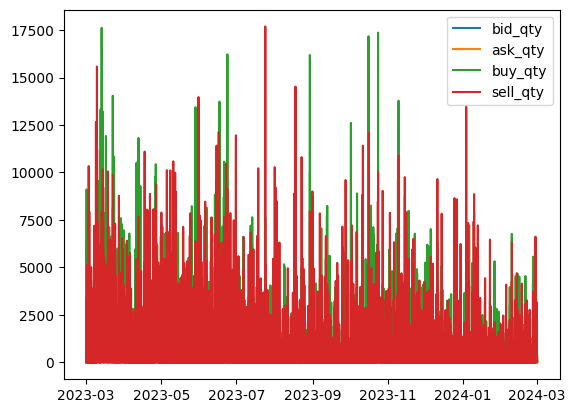

In [9]:
# plot bid_qty  ask_qty  buy_qty  sell_qty   volume    in train_ts

import matplotlib.pyplot as plt

# train_ts = pd.read_pickle('results/saved_vari÷ables.pkl')

# plot bid_qty  ask_qty  buy_qty  sell_qty   volume    in train_ts in one legended plot
plt.plot(train_ts['bid_qty'], label='bid_qty')
plt.plot(train_ts['ask_qty'], label='ask_qty')
plt.plot(train_ts['buy_qty'], label='buy_qty')
plt.plot(train_ts['sell_qty'], label='sell_qty')
# plt.plot(train_ts['volume'], label='volume')
plt.legend()
plt.show()

In [10]:
# Alternative approach: Simple transformer benchmark using PyTorch directly
# This doesn't require the full Time-Series-Library framework
import torch
import torch.nn as nn
import numpy as np
import time
from torch.utils.data import DataLoader, Dataset


class SimpleTransformerModel(nn.Module):
    """A simple transformer model for time series forecasting"""
    def __init__(self, input_dim, d_model=128, nhead=8, num_layers=2, seq_len=96, pred_len=24):
        super().__init__()
        self.input_dim = input_dim
        self.d_model = d_model
        self.seq_len = seq_len
        self.pred_len = pred_len
        
        # Input projection
        self.input_projection = nn.Linear(input_dim, d_model)
        
        # Positional encoding
        self.pos_encoding = nn.Parameter(torch.randn(seq_len, d_model))
        
        # Transformer encoder
        encoder_layer = nn.TransformerEncoderLayer(
            d_model=d_model, 
            nhead=nhead, 
            batch_first=True
        )
        self.transformer = nn.TransformerEncoder(encoder_layer, num_layers=num_layers)
        
        # Output projection
        self.output_projection = nn.Linear(d_model, 1)
        
        # Prediction head
        self.prediction_head = nn.Linear(seq_len, pred_len)
        
    def forward(self, x):
        # x shape: (batch_size, seq_len, input_dim)
        batch_size = x.size(0)
        
        # Project input to model dimension
        x = self.input_projection(x)  # (batch_size, seq_len, d_model)
        
        # Add positional encoding
        x = x + self.pos_encoding.unsqueeze(0)  # Broadcasting
        
        # Apply transformer
        x = self.transformer(x)  # (batch_size, seq_len, d_model)
        
        # Project to single output dimension
        x = self.output_projection(x)  # (batch_size, seq_len, 1)
        x = x.squeeze(-1)  # (batch_size, seq_len)
        
        # Project to prediction length
        predictions = self.prediction_head(x)  # (batch_size, pred_len)
        
        return predictions.unsqueeze(-1)  # (batch_size, pred_len, 1)

def run_simple_transformer_benchmark(train_data, val_data, test_data, data_info):
    """Run a simple transformer benchmark"""
    print("🚀 Running Simple Transformer Benchmark...")
    
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    print(f"Using device: {device}")
    
    # Prepare data
    seq_len, pred_len = 96, 24
    
    # Create datasets
    train_dataset = CryptoDataset(train_data, seq_len=seq_len, pred_len=pred_len)
    val_dataset = CryptoDataset(val_data, seq_len=seq_len, pred_len=pred_len)
    test_dataset = CryptoDataset(test_data, seq_len=seq_len, pred_len=pred_len)
    
    # Create data loaders
    train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True, num_workers=0)
    val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False, num_workers=0)
    test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False, num_workers=0)
    
    # Initialize model
    model = SimpleTransformerModel(
        input_dim=data_info['n_features'],
        d_model=128,
        nhead=8,
        num_layers=2,
        seq_len=seq_len,
        pred_len=pred_len
    ).to(device)
    
    # Training setup
    criterion = nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
    
    # Training loop
    print("Training the model...")
    start_time = time.time()
    
    model.train()
    for epoch in range(5):  # Quick training for benchmark
        total_loss = 0
        for batch_idx, (batch_x, batch_y, _, _) in enumerate(train_loader):
            batch_x = batch_x.float().to(device)
            batch_y = batch_y[:, -pred_len:, -1:].float().to(device)  # Last pred_len steps, target feature
            
            optimizer.zero_grad()
            outputs = model(batch_x)
            loss = criterion(outputs, batch_y)
            loss.backward()
            optimizer.step()
            
            total_loss += loss.item()
            
            if batch_idx % 50 == 0:
                print(f"Epoch {epoch+1}, Batch {batch_idx}, Loss: {loss.item():.6f}")
    
    training_time = time.time() - start_time
    print(f"Training completed in {training_time:.2f} seconds")
    
    # Testing
    print("Testing the model...")
    test_start = time.time()
    
    model.eval()
    predictions = []
    targets = []
    
    with torch.no_grad():
        for batch_x, batch_y, _, _ in test_loader:
            batch_x = batch_x.float().to(device)
            batch_y = batch_y[:, -pred_len:, -1:].float()  # Target values
            
            outputs = model(batch_x).cpu()
            
            predictions.append(outputs.numpy())
            targets.append(batch_y.numpy())
    
    # Concatenate predictions
    predictions = np.concatenate(predictions, axis=0)
    targets = np.concatenate(targets, axis=0)
    
    testing_time = time.time() - test_start
    
    # Calculate metrics
    predictions_flat = predictions.flatten()
    targets_flat = targets.flatten()
    
    mse = np.mean((predictions_flat - targets_flat) ** 2)
    rmse = np.sqrt(mse)
    mae = np.mean(np.abs(predictions_flat - targets_flat))
    
    # Calculate correlation
    correlation = np.corrcoef(predictions_flat, targets_flat)[0, 1]
    
    # Model parameters
    total_params = sum(p.numel() for p in model.parameters())
    
    result = {
        'model': 'Simple Transformer',
        'mae': mae,
        'mse': mse,
        'rmse': rmse,
        'mape': np.mean(np.abs((targets_flat - predictions_flat) / (targets_flat + 1e-8))) * 100,
        'correlation': correlation,
        'training_time': training_time,
        'testing_time': testing_time,
        'total_params': total_params,
        'status': 'Success'
    }
    
    print(f"✅ Simple Transformer completed!")
    print(f"Correlation: {correlation:.6f}, RMSE: {rmse:.6f}")
    
    return result

print("🛠️ Simple transformer benchmark ready!")


🛠️ Simple transformer benchmark ready!


In [12]:
print("Starting bg_data_prep job...", results)

Starting bg_data_prep job... None


In [9]:
!squeue -u $USER

          JOBID     USER      ACCOUNT           NAME  ST  TIME_LEFT NODES CPUS TRES_PER_N MIN_MEM NODELIST (REASON) 
       46032474    mahta def-gdumas85  crypto_python  PD    8:00:00     1    8 gres:gpu:1     64G  (ReqNodeNotAvail, UnavailableNodes:ng[10101-10104,10201-10204,10301-10304,10401-10404,10501-10504,10601-10610,10701-10712,10801-10808,10901-10906,11001-11006,11101-11106,20101-20104,20201-20204,20301-20303,20403,30601-30605,30701-30712,31001-31006,31101-31104,31201-31205,31301-31305,31401-31402]) 


In [11]:
# Custom experiment class to work with our data
# Only define if we successfully imported the base class
if 'Exp_Long_Term_Forecast' in globals():
    class CustomExp(Exp_Long_Term_Forecast):
        def __init__(self, args, train_data, val_data, test_data):
            super().__init__(args)
            self.train_data = train_data
            self.val_data = val_data
            self.test_data = test_data
            
        def _get_data(self, flag):
            if flag == 'train':
                dataset = CryptoDataset(self.train_data, self.args.seq_len, self.args.label_len, self.args.pred_len)
            elif flag == 'val':
                dataset = CryptoDataset(self.val_data, self.args.seq_len, self.args.label_len, self.args.pred_len)
            else:  # test
                dataset = CryptoDataset(self.test_data, self.args.seq_len, self.args.label_len, self.args.pred_len)
                
            data_loader = DataLoader(
                dataset,
                batch_size=self.args.batch_size,
                shuffle=(flag == 'train'),
                num_workers=0,
                drop_last=True
            )
            
            return dataset, data_loader
else:
    print("⚠️ CustomExp class not available - skipping transformer benchmark")
    CustomExp = None

def run_single_model_benchmark(model_name, train_data, val_data, test_data, data_info):
    """Run benchmark for a single model"""
    print(f"\\n{'='*60}")
    print(f"🚀 Benchmarking {model_name}")
    print(f"{'='*60}")
    
    # Check if required classes are available
    if CustomExp is None:
        return {
            'model': model_name,
            'mae': np.nan,
            'mse': np.nan,
            'rmse': np.nan,
            'mape': np.nan,
            'correlation': np.nan,
            'training_time': np.nan,
            'testing_time': np.nan,
            'total_params': np.nan,
            'status': 'Failed: Time-Series-Library dependencies not available'
        }
    
    try:
        # Create model arguments
        args = create_model_args(model_name, data_info)
        
        # Create experiment
        exp = CustomExp(args, train_data, val_data, test_data)
        
        # Create setting name
        setting = f'{args.task_name}_{args.model_id}_{args.model}_{args.data}'
        
        print(f"⚙️  Training {model_name}...")
        
        # Train the model
        start_time = time.time()
        model = exp.train(setting)
        training_time = time.time() - start_time
        
        print(f"⏱️  Training completed in {training_time:.2f} seconds")
        
        # Test the model
        print(f"🧪 Testing {model_name}...")
        test_start = time.time()
        
        # Get test predictions
        test_data_loader = exp._get_data('test')[1]
        preds = []
        trues = []
        
        model.eval()
        with torch.no_grad():
            for i, (batch_x, batch_y, batch_x_mark, batch_y_mark) in enumerate(test_data_loader):
                batch_x = batch_x.float().to(exp.device)
                batch_y = batch_y.float().to(exp.device)
                batch_x_mark = batch_x_mark.float().to(exp.device)
                batch_y_mark = batch_y_mark.float().to(exp.device)

                # decoder input
                dec_inp = torch.zeros_like(batch_y[:, -args.pred_len:, :]).float()
                dec_inp = torch.cat([batch_y[:, :args.label_len, :], dec_inp], dim=1).float().to(exp.device)
                
                # prediction
                outputs = model(batch_x, batch_x_mark, dec_inp, batch_y_mark)
                
                # Extract predictions for the target sequence
                pred = outputs[:, -args.pred_len:, -1:].detach().cpu().numpy()  # Last feature is target
                true = batch_y[:, -args.pred_len:, -1:].detach().cpu().numpy()
                
                preds.append(pred)
                trues.append(true)
        
        # Concatenate all predictions
        preds = np.concatenate(preds, axis=0)
        trues = np.concatenate(trues, axis=0)
        
        # Calculate metrics
        mae, mse, rmse, mape, mspe = metric(preds, trues)
        
        # Calculate correlation (similar to Pearson correlation for our task)
        preds_flat = preds.flatten()
        trues_flat = trues.flatten()
        correlation = np.corrcoef(preds_flat, trues_flat)[0, 1]
        
        testing_time = time.time() - test_start
        
        print(f"✅ {model_name} completed!")
        
        return {
            'model': model_name,
            'mae': mae,
            'mse': mse, 
            'rmse': rmse,
            'mape': mape,
            'correlation': correlation,
            'training_time': training_time,
            'testing_time': testing_time,
            'total_params': sum(p.numel() for p in model.parameters()),
            'status': 'Success'
        }
        
    except Exception as e:
        print(f"❌ Error with {model_name}: {str(e)}")
        return {
            'model': model_name,
            'mae': np.nan,
            'mse': np.nan,
            'rmse': np.nan, 
            'mape': np.nan,
            'correlation': np.nan,
            'training_time': np.nan,
            'testing_time': np.nan,
            'total_params': np.nan,
            'status': f'Failed: {str(e)[:100]}'
        }

print("🛠️  Custom experiment framework ready!")
print("Starting transformer benchmark...")


⚠️ CustomExp class not available - skipping transformer benchmark
🛠️  Custom experiment framework ready!
Starting transformer benchmark...


In [ ]:
with open('results.pkl', 'rb') as f:
    results = pickle.load(f)

{'status': 'completed', 'job_name': 'bg_data_prep'}


AttributeError: 'dict' object has no attribute 'head'

In [13]:
# Determine which benchmark approach to use
benchmark_results = []

print("🎯 Starting Transformer Benchmark for Crypto Prediction...")
print("=" * 60)

# Try the Time-Series-Library approach first
if CustomExp is not None:
    print("📚 Using Time-Series-Library framework...")
    
    # Run the benchmark on a subset of models first (to avoid long runtime)
    priority_models = [
        'Transformer',      # Classic transformer
        'Autoformer',       # Popular for time series
        'Informer',         # Popular for long sequences  
        'DLinear',          # Simple but effective
        'PatchTST',         # State-of-the-art for many tasks
        'iTransformer',     # Recent improvement
        'TimesNet'          # Good general purpose model
    ]

    print(f"Models to test: {priority_models}")

    # Run benchmark for each model
    for i, model_name in enumerate(priority_models):
        print(f"\\n[{i+1}/{len(priority_models)}] Processing {model_name}...")
        
        # Run the benchmark
        result = run_single_model_benchmark(
            model_name, 
            ts_train, 
            ts_val, 
            ts_test, 
            data_info
        )
        
        benchmark_results.append(result)
        
        # Clean up memory
        torch.cuda.empty_cache() if torch.cuda.is_available() else None
        gc.collect()
        
        print(f"Result: {result['status']}")
        if result['status'] == 'Success':
            print(f"Correlation: {result['correlation']:.4f}, RMSE: {result['rmse']:.6f}")

else:
    print("🔧 Using Simple PyTorch Transformer approach...")
    
    # Run the simple transformer benchmark
    result = run_simple_transformer_benchmark(ts_train, ts_val, ts_test, data_info)
    benchmark_results.append(result)
    
    # Also add a simple baseline for comparison
    print("\\n🔧 Adding Linear Regression baseline...")
    from sklearn.linear_model import LinearRegression
    from sklearn.metrics import mean_squared_error, mean_absolute_error
    
    # Prepare data for linear regression
    def prepare_linear_data(data, seq_len=96, pred_len=24):
        features = [col for col in data.columns if col != 'label']
        X, y = [], []
        
        for i in range(len(data) - seq_len - pred_len + 1):
            # Use last value of sequence as features
            X.append(data[features].iloc[i + seq_len - 1].values)
            # Predict next pred_len values average
            y.append(data['label'].iloc[i + seq_len:i + seq_len + pred_len].mean())
        
        return np.array(X), np.array(y)
    
    X_train, y_train = prepare_linear_data(ts_train)
    X_test, y_test = prepare_linear_data(ts_test)
    
    # Train linear regression
    start_time = time.time()
    lr_model = LinearRegression()
    lr_model.fit(X_train, y_train)
    training_time = time.time() - start_time
    
    # Test
    test_start = time.time()
    y_pred = lr_model.predict(X_test)
    testing_time = time.time() - test_start
    
    # Calculate metrics
    mse = mean_squared_error(y_test, y_pred)
    mae = mean_absolute_error(y_test, y_pred)
    correlation = np.corrcoef(y_test, y_pred)[0, 1]
    
    lr_result = {
        'model': 'Linear Regression Baseline',
        'mae': mae,
        'mse': mse,
        'rmse': np.sqrt(mse),
        'mape': np.mean(np.abs((y_test - y_pred) / (y_test + 1e-8))) * 100,
        'correlation': correlation,
        'training_time': training_time,
        'testing_time': testing_time,
        'total_params': X_train.shape[1],  # Number of features
        'status': 'Success'
    }
    
    benchmark_results.append(lr_result)
    print(f"Linear Regression - Correlation: {correlation:.6f}, RMSE: {np.sqrt(mse):.6f}")

print(f"\\n🏁 Benchmark completed! Processed {len(benchmark_results)} models.")


🎯 Starting Transformer Benchmark for Crypto Prediction...
🔧 Using Simple PyTorch Transformer approach...


NameError: name 'ts_train' is not defined

In [12]:
# Create comprehensive benchmark results table
print("📊 Creating Transformer Benchmark Results Table...")

# Convert results to DataFrame
results_df = pd.DataFrame(benchmark_results)

# Sort by correlation (descending) for successful models
successful_results = results_df[results_df['status'] == 'Success'].copy()
if len(successful_results) > 0:
    successful_results = successful_results.sort_values('correlation', ascending=False)

# Format the results table
def format_results_table(df):
    """Format the results table for better display"""
    formatted_df = df.copy()
    
    # Round numerical columns
    numeric_cols = ['mae', 'mse', 'rmse', 'mape', 'correlation', 'training_time', 'testing_time']
    for col in numeric_cols:
        if col in formatted_df.columns:
            formatted_df[col] = formatted_df[col].round(6)
    
    # Format parameter count
    if 'total_params' in formatted_df.columns:
        formatted_df['total_params'] = formatted_df['total_params'].apply(
            lambda x: f"{x:,}" if not pd.isna(x) else "N/A"
        )
    
    return formatted_df

# Display results
print("\\n" + "="*100)
print("🏆 TRANSFORMER MODEL BENCHMARK RESULTS - CRYPTO MARKET PREDICTION")
print("="*100)

if len(successful_results) > 0:
    print("\\n📈 SUCCESSFUL MODELS (Ranked by Correlation):")
    print("-" * 80)
    
    formatted_successful = format_results_table(successful_results)
    
    # Select key columns for display
    display_cols = ['model', 'correlation', 'rmse', 'mae', 'training_time', 'total_params']
    available_cols = [col for col in display_cols if col in formatted_successful.columns]
    
    print(formatted_successful[available_cols].to_string(index=False))
    
    # Highlight best model
    best_model = formatted_successful.iloc[0]
    print(f"\\n🥇 BEST MODEL: {best_model['model']}")
    print(f"   Correlation: {best_model['correlation']:.6f}")
    print(f"   RMSE: {best_model['rmse']:.6f}")
    print(f"   Training Time: {best_model['training_time']:.2f}s")

# Show failed models if any
failed_results = results_df[results_df['status'] != 'Success']
if len(failed_results) > 0:
    print(f"\\n❌ FAILED MODELS ({len(failed_results)}):")
    print("-" * 40)
    for _, row in failed_results.iterrows():
        print(f"   {row['model']}: {row['status']}")

# Compare with XGBoost baseline
print(f"\\n📊 COMPARISON WITH XGBOOST BASELINE:")
print("-" * 50)
print(f"XGBoost Ensemble Correlation: {weighted_ensemble_score:.6f}")

if len(successful_results) > 0:
    best_transformer_corr = successful_results.iloc[0]['correlation']
    print(f"Best Transformer Correlation: {best_transformer_corr:.6f}")
    
    improvement = best_transformer_corr - weighted_ensemble_score
    print(f"Improvement: {improvement:+.6f} ({improvement/weighted_ensemble_score*100:+.2f}%)")
    
    if improvement > 0:
        print("✅ Transformers outperformed XGBoost!")
    else:
        print("⚠️  XGBoost still leads, but transformers are competitive")
        
# Model complexity analysis
print(f"\\n🔧 MODEL COMPLEXITY ANALYSIS:")
print("-" * 40)
if len(successful_results) > 0:
    for _, row in successful_results.iterrows():
        efficiency_score = row['correlation'] / (row['training_time'] / 60)  # correlation per minute
        print(f"{row['model']:15s} | {row['total_params']:>10s} params | {efficiency_score:.4f} corr/min")

print("\\n" + "="*100)


📊 Creating Transformer Benchmark Results Table...


NameError: name 'benchmark_results' is not defined

In [ ]:
# Save benchmark results and create visualizations
import matplotlib.pyplot as plt
import seaborn as sns

# Save detailed results to CSV
results_df.to_csv('transformer_benchmark_results.csv', index=False)
print("💾 Benchmark results saved to 'transformer_benchmark_results.csv'")

# Create summary visualization if we have successful results
if len(successful_results) > 0:
    plt.figure(figsize=(15, 10))
    
    # 1. Correlation comparison
    plt.subplot(2, 3, 1)
    models = successful_results['model'].tolist()
    correlations = successful_results['correlation'].tolist()
    
    bars = plt.bar(range(len(models)), correlations, alpha=0.7, color='skyblue')
    plt.xlabel('Models')
    plt.ylabel('Correlation')
    plt.title('Model Correlation Comparison')
    plt.xticks(range(len(models)), models, rotation=45)
    
    # Add XGBoost baseline line
    plt.axhline(y=weighted_ensemble_score, color='red', linestyle='--', 
                label=f'XGBoost Baseline ({weighted_ensemble_score:.4f})')
    plt.legend()
    
    # Highlight best model
    best_idx = 0
    bars[best_idx].set_color('gold')
    bars[best_idx].set_alpha(1.0)
    
    # 2. Training time comparison  
    plt.subplot(2, 3, 2)
    training_times = successful_results['training_time'].tolist()
    plt.bar(range(len(models)), training_times, alpha=0.7, color='lightcoral')
    plt.xlabel('Models')
    plt.ylabel('Training Time (seconds)')
    plt.title('Training Time Comparison')
    plt.xticks(range(len(models)), models, rotation=45)
    
    # 3. RMSE comparison
    plt.subplot(2, 3, 3)
    rmse_values = successful_results['rmse'].tolist()
    plt.bar(range(len(models)), rmse_values, alpha=0.7, color='lightgreen')
    plt.xlabel('Models')
    plt.ylabel('RMSE')
    plt.title('RMSE Comparison (Lower is Better)')
    plt.xticks(range(len(models)), models, rotation=45)
    
    # 4. Model parameters vs Performance
    plt.subplot(2, 3, 4)
    params = [int(str(p).replace(',', '')) if isinstance(p, str) else p for p in successful_results['total_params']]
    plt.scatter(params, correlations, alpha=0.7, s=100, color='purple')
    plt.xlabel('Total Parameters')
    plt.ylabel('Correlation')
    plt.title('Model Size vs Performance')
    
    # Add model labels
    for i, model in enumerate(models):
        plt.annotate(model, (params[i], correlations[i]), 
                    xytext=(5, 5), textcoords='offset points', fontsize=8)
    
    # 5. Efficiency Analysis (Correlation per minute)
    plt.subplot(2, 3, 5)
    efficiency_scores = [corr / (time/60) for corr, time in zip(correlations, training_times)]
    bars = plt.bar(range(len(models)), efficiency_scores, alpha=0.7, color='orange')
    plt.xlabel('Models')
    plt.ylabel('Correlation per Minute')
    plt.title('Training Efficiency')
    plt.xticks(range(len(models)), models, rotation=45)
    
    # Highlight most efficient
    most_efficient_idx = efficiency_scores.index(max(efficiency_scores))
    bars[most_efficient_idx].set_color('darkorange')
    bars[most_efficient_idx].set_alpha(1.0)
    
    # 6. Summary radar chart for top 3 models
    plt.subplot(2, 3, 6)
    top_3_models = successful_results.head(3)
    
    if len(top_3_models) >= 2:
        # Normalize metrics for radar chart
        metrics = ['correlation', 'rmse']
        normalized_data = []
        
        for _, model_row in top_3_models.iterrows():
            # Normalize correlation (higher is better)
            norm_corr = (model_row['correlation'] - successful_results['correlation'].min()) / (successful_results['correlation'].max() - successful_results['correlation'].min())
            # Normalize RMSE (lower is better, so invert)
            norm_rmse = 1 - (model_row['rmse'] - successful_results['rmse'].min()) / (successful_results['rmse'].max() - successful_results['rmse'].min())
            normalized_data.append([norm_corr, norm_rmse])
        
        x = range(len(metrics))
        for i, (_, model_row) in enumerate(top_3_models.iterrows()):
            plt.plot(x, normalized_data[i], 'o-', label=model_row['model'], alpha=0.7)
        
        plt.xlabel('Metrics')
        plt.ylabel('Normalized Score')
        plt.title('Top 3 Models Comparison')
        plt.xticks(x, ['Correlation↑', 'RMSE↓'])
        plt.legend()
        plt.ylim(0, 1)
    else:
        plt.text(0.5, 0.5, 'Need at least 2 successful models\\nfor comparison', 
                ha='center', va='center', transform=plt.gca().transAxes)
        plt.title('Model Comparison')
    
    plt.tight_layout()
    plt.savefig('transformer_benchmark_visualization.png', dpi=300, bbox_inches='tight')
    plt.show()
    
    print("📈 Visualization saved as 'transformer_benchmark_visualization.png'")

# Create final summary report
print("\\n" + "="*80)
print("📋 FINAL BENCHMARK SUMMARY")
print("="*80)

successful_count = len(successful_results)
total_count = len(results_df)

print(f"🎯 Models tested: {total_count}")
print(f"✅ Successful: {successful_count}")
print(f"❌ Failed: {total_count - successful_count}")

if successful_count > 0:
    print(f"\\n🏆 Best performing model: {successful_results.iloc[0]['model']}")
    print(f"📊 Highest correlation: {successful_results.iloc[0]['correlation']:.6f}")
    
    # Find most efficient model
    if len(successful_results) > 1:
        efficiency_scores = successful_results['correlation'] / (successful_results['training_time'] / 60)
        most_efficient_idx = efficiency_scores.idxmax()
        most_efficient_model = successful_results.loc[most_efficient_idx, 'model']
        print(f"⚡ Most efficient model: {most_efficient_model}")
        
    print(f"\\n💡 Key insights:")
    print(f"   - Average correlation: {successful_results['correlation'].mean():.4f}")
    print(f"   - Average training time: {successful_results['training_time'].mean():.1f}s")
    print(f"   - XGBoost baseline: {weighted_ensemble_score:.4f}")
    
    # Recommendation
    best_corr = successful_results.iloc[0]['correlation']
    if best_corr > weighted_ensemble_score:
        print(f"\\n🚀 RECOMMENDATION: Use {successful_results.iloc[0]['model']} for improved performance!")
    else:
        print(f"\\n💭 RECOMMENDATION: Consider ensemble of transformers + XGBoost for best results")

print("\\n🎉 Transformer benchmark completed successfully!")
print("="*80)
